In [1]:
import torch

In [2]:
a = torch.ones([10,64,128])
b = torch.ones([64,128])


In [3]:
a.shape

torch.Size([10, 64, 128])

In [4]:
b.shape

torch.Size([64, 128])

In [22]:
a = torch.ones([2,5])
b = torch.zeros([2,8])
c = torch.cat((a,b),dim=-1)

In [23]:
c

tensor([[1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [6]:
c.shape

torch.Size([10, 64, 128])

In [7]:
d = torch.zeros([10,64,1])

In [8]:
torch.cat((a,c),dim=-1).shape

torch.Size([10, 64, 256])

In [9]:
e=a*d

In [10]:
e.shape

torch.Size([10, 64, 128])

In [2]:
import spacy

In [3]:
from torchtext.datasets import Multi30k
from torchtext.data import Field,BucketIterator

In [4]:
spacy_eng = spacy.load('en_core_web_sm')
spacy_ger = spacy.load('de_core_news_sm')

In [5]:
def tokenize_eng(text):
    return([tok.text for tok in spacy_eng.tokenizer(text)])

In [6]:
def tokenize_ger(text):
    return([tok.text for tok in spacy_ger.tokenizer(text)])

In [7]:
english = Field(sequential=True, use_vocab=True, tokenize=tokenize_eng, lower=True,init_token='<sos>',eos_token='<eos>')
german = Field(sequential=True, use_vocab=True, tokenize=tokenize_ger, lower=True,init_token='<sos>',eos_token='<eos>')

C:\ProgramData\Anaconda3\envs\project2\lib\site-packages\torchtext\data\field.py:150: UserWarning: Field class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [8]:
train_data, validation_data, test_data = Multi30k.splits(exts=('.de','.en'),fields=(german,english))

C:\ProgramData\Anaconda3\envs\project2\lib\site-packages\torchtext\data\example.py:78: UserWarning: Example class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('Example class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.', UserWarning)


In [9]:
english.build_vocab(train_data,max_size=10000,min_freq=2)
german.build_vocab(train_data,max_size=10000,min_freq=2)

In [10]:
english.vocab.stoi['<eos>']

3

In [11]:
english.vocab.itos[5]

'.'

In [12]:
print(len(english.vocab))
print(len(german.vocab))

5893
7854


In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as f
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import time

In [14]:
class Encoder(nn.Module):
    def __init__(self,vocab_size,embedding,hidden_size,num_layers):
        super(Encoder,self).__init__()
        self.embedding_size = embedding
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.vocab_size = vocab_size
        self.embedding = nn.Embedding(vocab_size,embedding)
        self.lstm = nn.LSTM(embedding,hidden_size,num_layers=num_layers)
        
    def forward(self,x,hidden,cell):
                                                     # x : seqlen, batch
        x = self.embedding(x)                   # x : seqlen, batch, embedding   # input lstm : seqlen, batch, input_size
        x,(hidden,cell) = self.lstm(x,(hidden,cell))     # outputlstm : seq_len, batch, num_directions * hidden_size
        return(x,(hidden,cell))
        
    def initHidden(self,batch_size):
        return(torch.zeros([self.num_layers,batch_size,self.hidden_size]))  #hidden : num_layers * num_directions, batch, hidden_size

In [15]:
class Decoder(nn.Module):
    def __init__(self,vocab_size,embedding,hidden_size,num_layers):
        super(Decoder,self).__init__()
        self.vocab_size = vocab_size
        self.embedding_size = embedding
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size,embedding)
        self.lstm = nn.LSTM(embedding,hidden_size,num_layers=num_layers)
        self.fc = nn.Linear(self.hidden_size+self.embedding_size,self.embedding_size)
        
    def forward(self,x,c,hidden,cell):
        batch_size = x.shape[0]
        x = self.embedding(x)
        x = torch.cat((x,c.view(batch_size,-1)),dim=-1)
        x = self.fc(x)
        x = x.view(1,batch_size,self.embedding_size)
        x,(hidden,cell) = self.lstm(x,(hidden,cell))
        return(x,(hidden,cell))
        
    def initHidden(self,batch_size):
        return(torch.zeros([self.num_layers,batch_size,self.hidden_size]))

In [27]:
class Translate(nn.Module):
    def __init__(self,encoder,decoder,hidden_size,output_size):
        super(Translate,self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.softmax = nn.Softmax(dim=0)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(2*hidden_size,output_size)
        self.tanh = nn.Tanh()
        
    
    def forward(self,source,target):
        batch_size = source.shape[-1]
        hidden = self.encoder.initHidden(batch_size).to(device)
        cell = self.encoder.initHidden(batch_size).to(device)
        enc_hidden,(hidden,cell) = self.encoder(source,hidden,cell)   # # outputlstm : enc_seq_len, batch, hidden_size  
        
        dec_seq_len = target.shape[0]-1
        enc_seq_len = source.shape[0]
        out = torch.zeros([dec_seq_len,batch_size,self.output_size]).to(device)
        
        c = torch.zeros([batch_size,self.hidden_size]).to(device)
        #Attention procedure. dot product based
        for i in range(dec_seq_len):
    
            dec_hidden,(hidden,cell) = self.decoder(target[i,:],c,hidden,cell) 
            h = dec_hidden[0]              # batch, hidden
            a = torch.sum(torch.mul(enc_hidden,h),axis=-1)  #a = enc_seq_len, batch
            #print(a.shape)
            a = self.softmax(a)
            c = torch.sum(torch.mul(enc_hidden,a.view(enc_seq_len,batch_size,1)),axis=0)   #c = batch, hidden
            c = self.tanh(c)
            #print(c.shape,h.shape)
            out[i,:,:] = self.fc(torch.cat((c,h),dim=-1))
        
        return(out)

In [28]:
english_vocab_size = len(english.vocab)
german_vocab_size = len(german.vocab)
embedding = 50
output_size = english_vocab_size
hidden_size = 128
num_layers = 4
batch_size = 64
learning_rate = 0.01
epochs = 5
device='cuda'

In [29]:
train_iterator, validation_iterator, test_iterator = BucketIterator.splits((train_data,validation_data,test_data),
                                                                          batch_size=batch_size,device=device)

In [30]:
encoder = Encoder(german_vocab_size,embedding,hidden_size,num_layers)
decoder = Decoder(english_vocab_size,embedding,hidden_size,num_layers)
model = Translate(encoder,decoder,hidden_size,output_size).to(device)
optimizer = optim.Adam(model.parameters(),lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [31]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 3,187,697 trainable parameters


In [32]:
loss_lst = []
for epoch in range(epochs):
    epoch_loss = []
    t1 = time.time()
    for batch in train_iterator:
        t11 = time.time()
        batch_loss = []
        source = batch.src
        target = batch.trg   #target = encseq_len, batch
        #print(target.shape)
        batch_size = source.shape[-1]
        out = model(source,target)   # out = dec_seq_len, batch, output_size    
        #print(out.shape)
        #print(target.shape)    
        model.zero_grad()
        optimizer.zero_grad()
            
        out = out.view(-1,english_vocab_size).to(device)
        target = target[1:,:].view(-1)
        #print(out.shape)
        #print(target.shape)  
        loss = criterion(out,target)
        batch_loss.append(loss.item())
            
        loss.backward()
        optimizer.step()
        epoch_loss += batch_loss
        t22 = time.time()
        #print("batch loss : {}  ||  time : {}".format(np.mean(batch_loss),t22-t11))
        print(".",end="")
    loss_lst += epoch_loss
    t2 = time.time()
    print()
    print("mean epoch loss : {}  ||  time : {}".format(np.mean(epoch_loss),t2-t1))

...............

RuntimeError: CUDA out of memory. Tried to allocate 48.00 MiB (GPU 0; 2.00 GiB total capacity; 316.95 MiB already allocated; 40.14 MiB free; 350.00 MiB reserved in total by PyTorch)
Exception raised from malloc at ..\c10\cuda\CUDACachingAllocator.cpp:272 (most recent call first):
00007FFB369A75A200007FFB369A7540 c10.dll!c10::Error::Error [<unknown file> @ <unknown line number>]
00007FFB30B49C0600007FFB30B49B90 c10_cuda.dll!c10::CUDAOutOfMemoryError::CUDAOutOfMemoryError [<unknown file> @ <unknown line number>]
00007FFB30B5069600007FFB30B4F370 c10_cuda.dll!c10::cuda::CUDACachingAllocator::init [<unknown file> @ <unknown line number>]
00007FFB30B5083A00007FFB30B4F370 c10_cuda.dll!c10::cuda::CUDACachingAllocator::init [<unknown file> @ <unknown line number>]
00007FFB30B4509900007FFB30B44EB0 c10_cuda.dll!c10::cuda::CUDAStream::unpack [<unknown file> @ <unknown line number>]
00007FFAD2B51FF100007FFAD2B51EB0 torch_cuda.dll!at::native::empty_cuda [<unknown file> @ <unknown line number>]
00007FFAD2C68AFE00007FFAD2C0E0A0 torch_cuda.dll!at::native::set_storage_cuda_ [<unknown file> @ <unknown line number>]
00007FFAD2C642A500007FFAD2C0E0A0 torch_cuda.dll!at::native::set_storage_cuda_ [<unknown file> @ <unknown line number>]
00007FFAFA3A1A3A00007FFAFA38D9D0 torch_cpu.dll!at::native::mkldnn_sigmoid_ [<unknown file> @ <unknown line number>]
00007FFAFA3A000500007FFAFA38D9D0 torch_cpu.dll!at::native::mkldnn_sigmoid_ [<unknown file> @ <unknown line number>]
00007FFAFA4718A000007FFAFA468FA0 torch_cpu.dll!at::bucketize_out [<unknown file> @ <unknown line number>]
00007FFAFA4828DC00007FFAFA482850 torch_cpu.dll!at::empty [<unknown file> @ <unknown line number>]
00007FFAFA245C6100007FFAFA245780 torch_cpu.dll!at::native::empty_like [<unknown file> @ <unknown line number>]
00007FFAFA5471C200007FFAFA4CD060 torch_cpu.dll!at::zeros_out [<unknown file> @ <unknown line number>]
00007FFAFA0021EE00007FFAF9FF6470 torch_cpu.dll!torch::nn::functional::BatchNormFuncOptions::~BatchNormFuncOptions [<unknown file> @ <unknown line number>]
00007FFAFA46F44F00007FFAFA468FA0 torch_cpu.dll!at::bucketize_out [<unknown file> @ <unknown line number>]
00007FFAFA482C8200007FFAFA482C00 torch_cpu.dll!at::empty_like [<unknown file> @ <unknown line number>]
00007FFAD23C022600007FFAD23B3E60 torch_cuda.dll!at::native::cat_out_cuda [<unknown file> @ <unknown line number>]
00007FFAD23DBD4A00007FFAD23DBCC0 torch_cuda.dll!at::native::log_softmax_backward_cuda [<unknown file> @ <unknown line number>]
00007FFAD2C5386D00007FFAD2C0E0A0 torch_cuda.dll!at::native::set_storage_cuda_ [<unknown file> @ <unknown line number>]
00007FFAD2C61A6800007FFAD2C0E0A0 torch_cuda.dll!at::native::set_storage_cuda_ [<unknown file> @ <unknown line number>]
00007FFAFA46EC6600007FFAFA468FA0 torch_cpu.dll!at::bucketize_out [<unknown file> @ <unknown line number>]
00007FFAFA4568FE00007FFAFA456890 torch_cpu.dll!at::_log_softmax_backward_data [<unknown file> @ <unknown line number>]
00007FFAFB7E2BE000007FFAFB70E010 torch_cpu.dll!torch::autograd::GraphRoot::apply [<unknown file> @ <unknown line number>]
00007FFAFA000B2800007FFAF9FF6470 torch_cpu.dll!torch::nn::functional::BatchNormFuncOptions::~BatchNormFuncOptions [<unknown file> @ <unknown line number>]
00007FFAFA46EC6600007FFAFA468FA0 torch_cpu.dll!at::bucketize_out [<unknown file> @ <unknown line number>]
00007FFAFA4568FE00007FFAFA456890 torch_cpu.dll!at::_log_softmax_backward_data [<unknown file> @ <unknown line number>]
00007FFAFB6699DC00007FFAFB669870 torch_cpu.dll!torch::autograd::generated::LogSoftmaxBackward::apply [<unknown file> @ <unknown line number>]
00007FFAFB647E9100007FFAFB647B50 torch_cpu.dll!torch::autograd::Node::operator() [<unknown file> @ <unknown line number>]
00007FFAFBBAF9BA00007FFAFBBAF300 torch_cpu.dll!torch::autograd::Engine::add_thread_pool_task [<unknown file> @ <unknown line number>]
00007FFAFBBB03AD00007FFAFBBAFFD0 torch_cpu.dll!torch::autograd::Engine::evaluate_function [<unknown file> @ <unknown line number>]
00007FFAFBBB4FE200007FFAFBBB4CA0 torch_cpu.dll!torch::autograd::Engine::thread_main [<unknown file> @ <unknown line number>]
00007FFAFBBB4C4100007FFAFBBB4BC0 torch_cpu.dll!torch::autograd::Engine::thread_init [<unknown file> @ <unknown line number>]
00007FFB16EF08F700007FFB16EC9F80 torch_python.dll!THPShortStorage_New [<unknown file> @ <unknown line number>]
00007FFAFBBABF1400007FFAFBBAB780 torch_cpu.dll!torch::autograd::Engine::get_base_engine [<unknown file> @ <unknown line number>]
00007FFB654510B200007FFB65450F70 ucrtbase.dll!beginthreadex [<unknown file> @ <unknown line number>]
00007FFB66427C2400007FFB66427C10 KERNEL32.DLL!BaseThreadInitThunk [<unknown file> @ <unknown line number>]
00007FFB683CD4D100007FFB683CD4B0 ntdll.dll!RtlUserThreadStart [<unknown file> @ <unknown line number>]


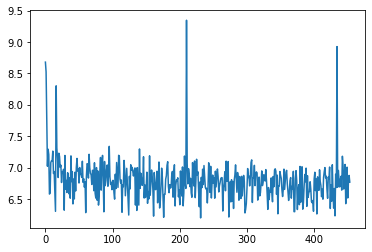

In [55]:
plt.plot(loss_lst)

In [132]:
torch.save(model.state_dict(),'Attention2.pth') 

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\envs\project2\lib\asyncio\events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "C:\ProgramData\Anaconda3\envs\project2\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\envs\project2\lib\asyncio\events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "C:\ProgramData\Anaconda3\envs\project2\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinE

In [98]:
#sentence = 'ich habe kein interesse am spielen .' # 'i dont have intrest in playing'
#sentence = 'ich bin heute glücklich .'  # 'i am happy today'
#sentence = 'eine frau mochte dieses gebäude .' # 'a woman liked that building'
#sentence = 'eines tages werde ich reich sein .'  # 'one day i will be rich'
sentence = 'ein mann lehnt sich in der nähe einer belebten straße an ein gebäude .'  # 'a man leans against a building near a busy street .'
#sentence = 'wer bin ich .'   # 'who am i'
#sentence = 'ein läufer <unk> sich für ein rennen aus dem <unk> .'  #runner leaving the starting blocks of a race .
sentence = sentence.split()
a = torch.zeros([len(sentence)+2],dtype=torch.long)
a[0] = 2
a[-1]  = 3
#a[1] = 1180
for i in range(0,len(sentence)):
    a[i+1] = german.vocab.stoi[sentence[i]]
    
print(a)
print(sentence)

tensor([  2,   5,  13, 287,  23,   7,  15, 110,  14, 340,  34,  21,   5, 104,
          4,   3])
['ein', 'mann', 'lehnt', 'sich', 'in', 'der', 'nähe', 'einer', 'belebten', 'straße', 'an', 'ein', 'gebäude', '.']


In [115]:
translation = ''

word = '<sos>'
word_index = 2


while word!='<eos>':
    
    out = model(a.view(a.shape[0],1).to(device),torch.tensor([2,3]).view(2,1).to(device))
    word_index = out.argmax(axis=-1)
    word = english.vocab.itos[word_index]
    out = torch.tensor([word_index])
    if word != '<eos>':
        translation += word + " "
        
print(translation)

torch.Size([1])


KeyboardInterrupt: 

In [116]:
translation

'gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gather gathe

In [107]:
torch.tensor([2,3]).view(2,1).shape

torch.Size([2, 1])